In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv
from matplotlib.lines import Line2D

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})
RESULT_DIR='../icemu/log/'

In [5]:
from BenchmarkConfiguration import *

# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'clank',
    'nacho-naive',
    'nacho-pw',
    'nacho-clank',
    'prowl',
]

Stats = [
    'checkpoints','cycle count','last checkpoint','dirty ratio','cause'
]

CacheConfig = [ "-512-2-", "-256-2-", "-1024-2-", "-512-4-", "-256-4-", "-1024-4-", "-8192-2-", "-8192-4-"]

FinalStats = [
    'cache_miss', 
    'cache_hit', 
    'cache_read', 
    'cache_write', 
    'cache_cuckoo', 
    'cache_checkpoint', 
    'nvm_reads_no_cache', 
    'nvm_writes_no_cache', 
    'nvm_reads', 
    'nvm_writes', 
    'checkpoint', 
    'checkpoint_war', 
    'checkpoint_dirty', 
    'checkpoint_period', 
    'checkpoint_max_cycles', 
    'hints_given', 
    'max_dirty_ratio', 
    'cuckoo_iter',
    'cycle'
]

In [6]:
# Load the benchmarks
def load_cont_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return pd.read_csv(file + "cont").set_index("checkpoints")

def load_final_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return dict(pd.read_csv(file + "final", delimiter=":", header = None).values)

cont_stats = {}
final_stats = {}

# # For bmarks
# clank_stats = {}
# for bench in Benchmarks:
#     clank_stats[bench] = dict(pd.read_csv(RESULT_DIR + bench + "-clank-final", delimiter=":", header = None).values)


# for cache in CacheConfig:
#     final_stats[cache]["clank"] = clank_stats

for cache in CacheConfig:
    cont_stats[cache] = {}
    final_stats[cache] = {}
    for config in Configurations:
        if cache in ["-256-4-", "-512-4-", "-1024-4-", "-8192-4-"] and config == "prowl":
            continue
        cont_stats[cache][config] = {}
        final_stats[cache][config] = {}
        for bench in Benchmarks:
            if config == 'clank':
                final_stats[cache][config][bench] = dict(pd.read_csv(RESULT_DIR + bench + "-clank-final", delimiter=":", header = None).values)
                continue
            cont_stats[cache][config][bench] = load_cont_stats(bench, config, cache)
            final_stats[cache][config][bench] = load_final_stats(bench, config, cache)

In [230]:
for b in Benchmarks:
    print(b + " ====")
    # print(final_stats['-256-2-']['clank'][b]['checkpoint'])
    # print(final_stats['-256-2-']['nacho-naive'][b]['checkpoint'])
    print(final_stats['-256-2-']['clank'][b]['checkpoint'] - final_stats['-256-2-']['nacho-pw'][b]['checkpoint'])
    

coremark ====
39559
sha ====
82969
crc ====
263
aes ====
-691.0
dijkstra ====
20137
picojpeg ====
662885


In [8]:
from Color import *

X = np.arange(len(Benchmarks))
step_size = 1 / (len(Configurations) + 1) 

cache_config_used = None

def fetchNormalizingFactor(bmark, requested_stats):
    normalizing_factor = []
    for b in final_stats[cache_config_used][bmark]:
        val = 0
        for e in requested_stats:
            val = val + final_stats[cache_config_used][bmark][b][e]
        
        normalizing_factor.append(val)

    return normalizing_factor


def plotStatPerBenchmark(ax, requested_stats, normalizing_bmark, title, mean_stat = "dirty_ratio", startColor=0, ignore=[]):
    step = 0.00
    idx_work = 0
    put_a_x = 0


    ax.set_ylabel('Normalized ratio')
    if normalizing_bmark is not None:
        ax.set_title(title + ' normalized to ' + normalizing_bmark)
    
    if title == "":
        ax.set_title("")

    normalize = np.asarray(np.ones(len(Benchmarks)))
    if normalizing_bmark is not None:
        normalize = fetchNormalizingFactor(normalizing_bmark, requested_stats)
    
    # For each work
    for works in final_stats[cache_config_used]:
        if works in ignore:
            continue
        
        to_plot = np.zeros(len(Benchmarks))
        idx_stat = startColor
        
        # For each stack in the bar plot - stats
        for stats in requested_stats:
#             print("For " + str(stats))
            curr_stats = []
            
            # For each bmark
            for bmarks in final_stats[cache_config_used][works]:
                curr_stats.append(final_stats[cache_config_used][works][bmarks][stats])
                
            # Normalize the stats
            curr_stats = list(map(truediv, curr_stats, normalize))
            
            # plot the stacked bar
            line = ax.bar(X + step,
                           curr_stats,
                           bottom = to_plot,
                           linewidth = 1,
                           joinstyle = 'miter',
                        #    hatch = patterns[idx_stat],
                           color = StackedBarColors[idx_work][3 - idx_stat],
                           alpha = 1 - 0.15 * idx_stat,
                           edgecolor = 'white',
                           width = 4.5 * step_size / 5)

            # increment the stack
            to_plot = to_plot + curr_stats

            # N colors for N stats
            idx_stat = idx_stat + 1
            # print(idx_stat)
        
        # s = 0
        # for i in to_plot:
        #     if (i == 0):
        #         ax.text(s, 0, "x",
        #                 color = Color['red'],
        #                 fontsize = 'x-large')
        #     s = s + 1
        
        # Three colors for 3 works
        idx_work = idx_work + 1
        # print(idx_work)

        # Separating each bmark
        step = step + step_size

['nacho-naive', 'nacho-pw', 'nacho-clank']

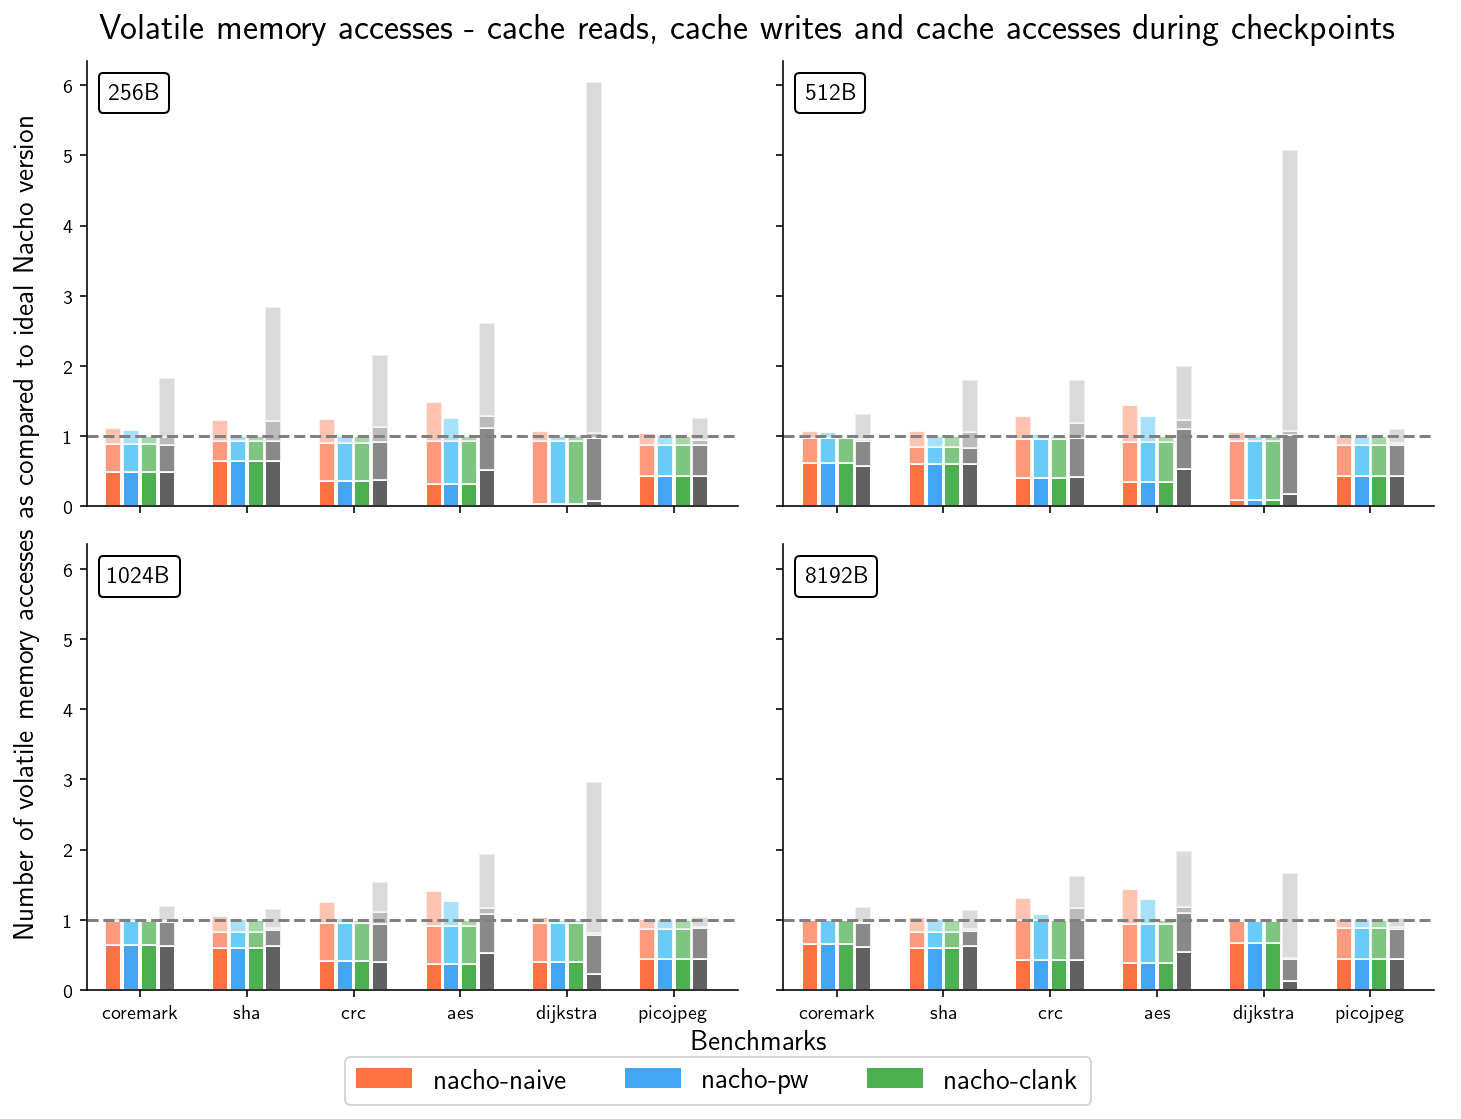

In [240]:
# Uncomment/change what stats which are needed to be plotted
stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint', 'cache_cuckoo']
stats_desc = ['read', 'write', 'checkpoint']
title = 'Volatile memory accesses'
normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

fig, ax_np = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,7), sharey=True);
fig.tight_layout(pad=1);
ylegend = 1.2

ax = [None, None, None, None]
k = 0
for i in range(2):
    for j in range(2):
        ax[k] = ax_np[i][j]
        k = k + 1

for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks, fontsize=14);
isCheckpoints = False

# Do the actual plotting
def doActualPlotting(thisax, cache_config, stats, norm, title, cache_text):
    global cache_config_used
    cache_config_used = cache_config
    plotStatPerBenchmark(thisax, stats, norm, title, ignore=['clank']);
    at = AnchoredText(cache_text, prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    thisax.add_artist(at)
    thisax.set_ylabel("")

doActualPlotting(ax[0], "-256-2-", stats_plotted, normalizationBmark, "", "256B")
doActualPlotting(ax[1], "-512-2-", stats_plotted, normalizationBmark, "", "512B")
doActualPlotting(ax[2], "-1024-2-", stats_plotted, normalizationBmark, "", "1024B")
doActualPlotting(ax[3], "-8192-2-", stats_plotted, normalizationBmark, "", "8192B")

# A horizontal ref line
for a in ax:
    a.axhline(1, color="grey", linestyle='--')

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations[1:-1];

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-0.6, -0.255, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Volatile memory accesses - cache reads, cache writes and cache accesses during checkpoints',fontsize=18, x=0.5, y=1.02);

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
plt.ylabel("Number of volatile memory accesses as compared to ideal Nacho version", fontsize=14);
plt.xlabel("Benchmarks", fontsize=14);

fig.savefig('plots/volatile-caches-variation.pdf', bbox_inches='tight');

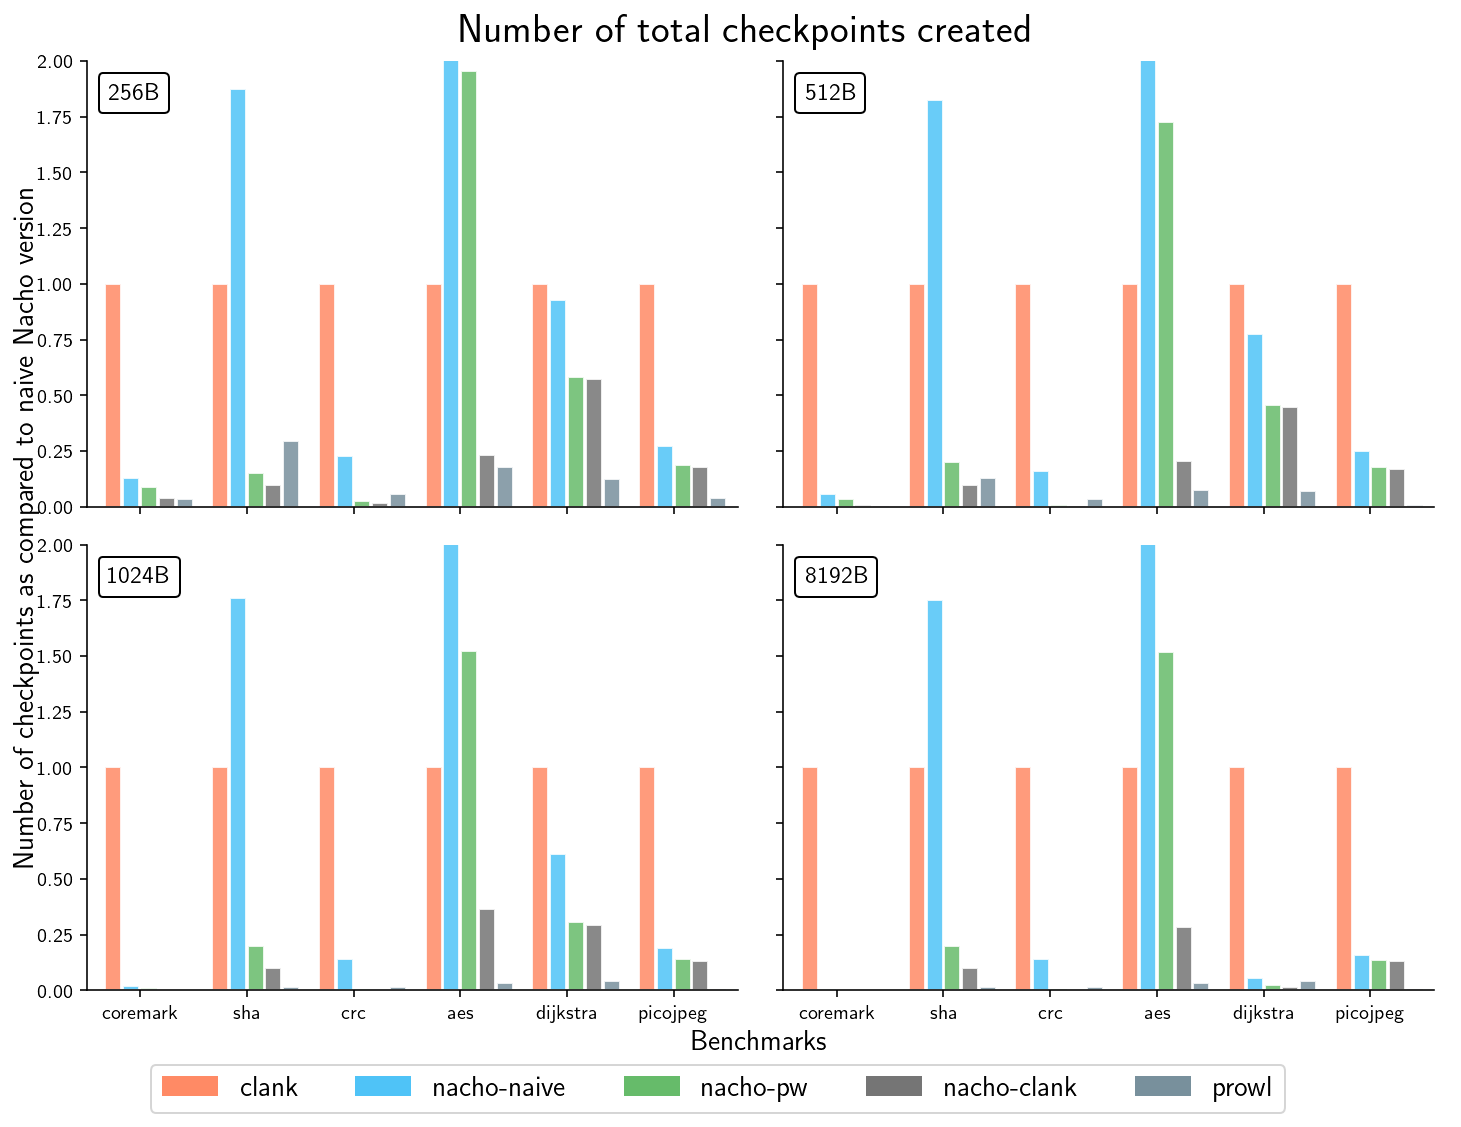

In [239]:
# Uncomment/change what stats which are needed to be plotted
# stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
# stats_desc = ['read', 'write', 'checkpoint']
# title = 'Volatile memory accesses'
# normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

stats_plotted = ['checkpoint']
stats_desc = ['WAR', 'ditry ratio', 'period']
title = 'Number of Checkpoints'
normalizationBmark = "clank"
isCheckpoints = True

fig, ax_np = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,7), sharey=True);
fig.tight_layout(pad=1);
ylegend = 1.2

ax = [None, None, None, None]
k = 0
for i in range(2):
    for j in range(2):
        ax[k] = ax_np[i][j]
        k = k + 1

for a in ax:
    a.set_ylim(ymax=2)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);


ax[0].set_xticks(X + 0.25, Benchmarks, fontsize=14);
isCheckpoints = False

# Do the actual plotting
def doActualPlotting(thisax, cache_config, stats, norm, title, cache_text):
    global cache_config_used
    cache_config_used = cache_config
    plotStatPerBenchmark(thisax, stats, norm, title, startColor=1);
    at = AnchoredText(cache_text, prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    thisax.add_artist(at)
    thisax.set_ylabel("")


doActualPlotting(ax[0], "-256-2-", stats_plotted, normalizationBmark, "", "256B")
doActualPlotting(ax[1], "-512-2-", stats_plotted, normalizationBmark, "", "512B")
doActualPlotting(ax[2], "-1024-2-", stats_plotted, normalizationBmark, "", "1024B")
doActualPlotting(ax[3], "-8192-2-", stats_plotted, normalizationBmark, "", "8192B")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][2]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-0.6, -0.272, 1., .102), 
            loc='center', fancybox=True,
            ncol=5, fontsize=14);

sup = plt.suptitle('Number of total checkpoints created',fontsize=20, x=0.5, y=1.02);

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
plt.ylabel("Number of checkpoints as compared to naive Nacho version", fontsize=14);
plt.xlabel("Benchmarks", fontsize=14);

fig.savefig('plots/checkpoint-caches-variation.pdf', bbox_inches='tight');

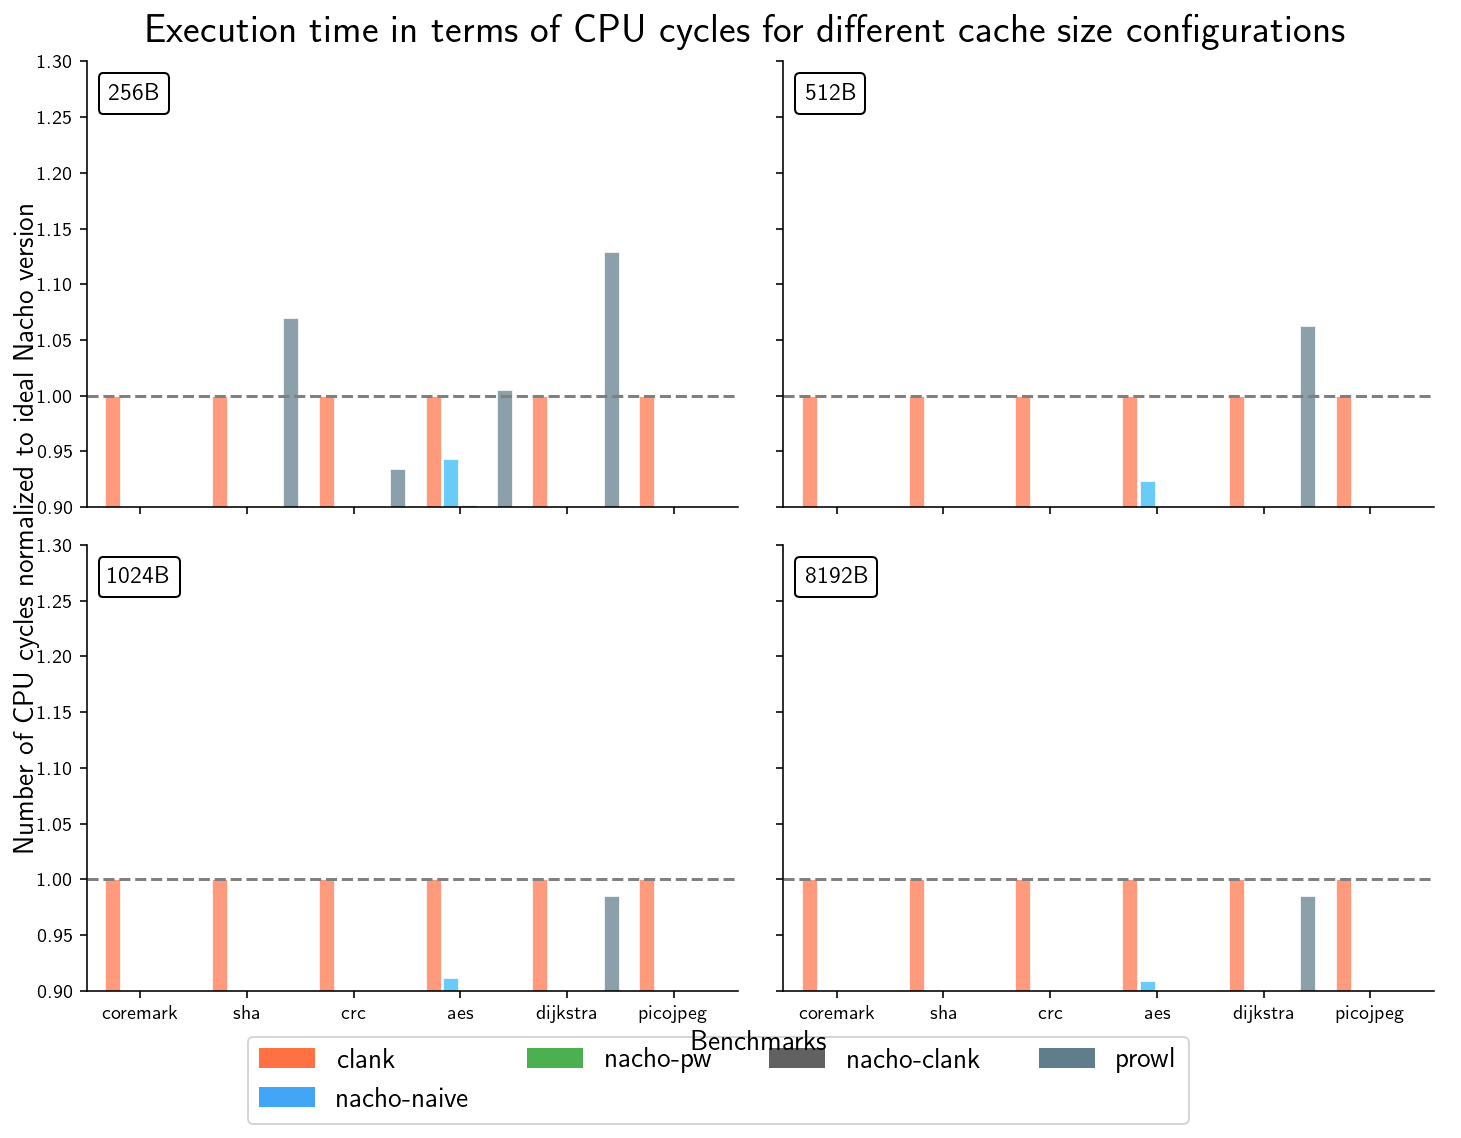

In [10]:
# Uncomment/change what stats which are needed to be plotted
# stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
# stats_desc = ['read', 'write', 'checkpoint']
# title = 'Volatile memory accesses'
# normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

stats_plotted = ['cycle']
stats_desc = ['Execution Cycle']
title = 'Number of cycles'
normalizationBmark = "clank"
isCheckpoints = True

fig, ax_np = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,7), sharey=True);
fig.tight_layout(pad=1);
ylegend = 1.2

ax = [None, None, None, None]
k = 0
for i in range(2):
    for j in range(2):
        ax[k] = ax_np[i][j]
        k = k + 1

for a in ax:
    a.set_ylim(ymin=0.9, ymax = 1.3)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks, fontsize=14);
isCheckpoints = False

# Do the actual plotting
def doActualPlotting(thisax, cache_config, stats, norm, title, cache_text):
    global cache_config_used
    cache_config_used = cache_config
    plotStatPerBenchmark(thisax, stats, norm, title, startColor=1);
    at = AnchoredText(cache_text, prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    thisax.add_artist(at)
    thisax.set_ylabel("")

doActualPlotting(ax[0], "-256-2-", stats_plotted, normalizationBmark, "", "256B")
doActualPlotting(ax[1], "-512-2-", stats_plotted, normalizationBmark, "", "512B")
doActualPlotting(ax[2], "-1024-2-", stats_plotted, normalizationBmark, "", "1024B")
doActualPlotting(ax[3], "-8192-2-", stats_plotted, normalizationBmark, "", "8192B")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for a in ax:
    a.axhline(1, color='grey', linestyle='--')

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-0.6, -0.252, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Execution time in terms of CPU cycles for different cache size configurations',fontsize=20, x=0.5, y=1.02);

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
plt.ylabel("Number of CPU cycles normalized to ideal Nacho version", fontsize=14);
plt.xlabel("Benchmarks", fontsize=14);

fig.savefig('plots/execution-caches-size-variation.pdf', bbox_inches='tight');

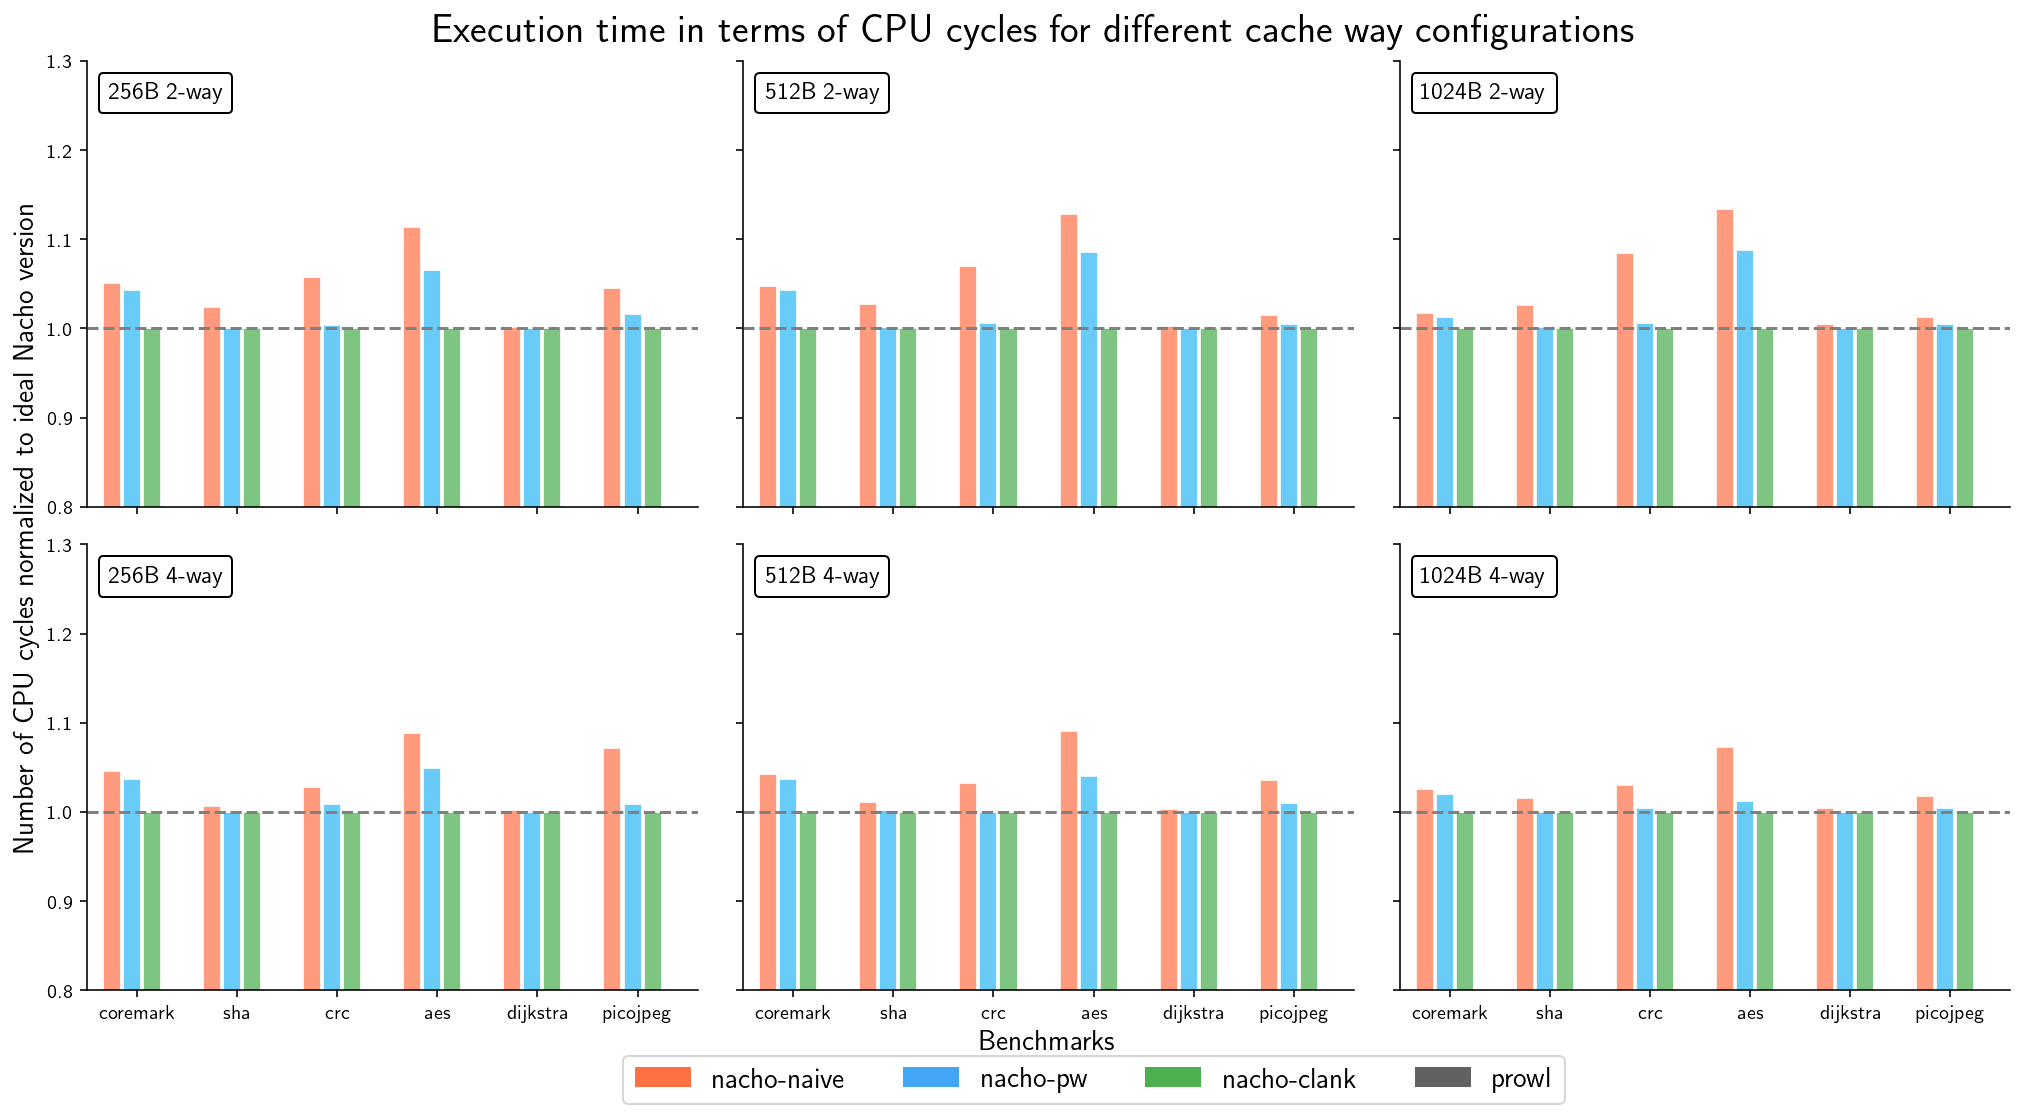

In [168]:
# Uncomment/change what stats which are needed to be plotted
# stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
# stats_desc = ['read', 'write', 'checkpoint']
# title = 'Volatile memory accesses'
# normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

stats_plotted = ['cycle']
stats_desc = ['Execution Cycle']
title = 'Number of cycles'
normalizationBmark = "nacho-clank"
isCheckpoints = True

fig, ax_np = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(14,7), sharey=True);
fig.tight_layout(pad=1);
ylegend = 1.2

ax = [None, None, None, None, None, None]
k = 0
for i in range(2):
    for j in range(3):
        ax[k] = ax_np[i][j]
        k = k + 1

for a in ax:
    a.set_ylim(ymin=0.8, ymax = 1.3) #ymin=0.8, ymax = 1.05
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks, fontsize=14);
isCheckpoints = False

# Do the actual plotting
def doActualPlotting(thisax, cache_config, stats, norm, title, cache_text):
    global cache_config_used
    cache_config_used = cache_config
    plotStatPerBenchmark(thisax, stats, norm, title, startColor=1, ignore=["prowl"]);
    at = AnchoredText(cache_text, prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    thisax.add_artist(at)
    thisax.set_ylabel("")

doActualPlotting(ax[0], "-256-2-", stats_plotted, normalizationBmark, "", "256B 2-way")
doActualPlotting(ax[3], "-256-4-", stats_plotted, normalizationBmark, "", "256B 4-way")
doActualPlotting(ax[1], "-512-2-", stats_plotted, normalizationBmark, "", "512B 2-way")
doActualPlotting(ax[4], "-512-4-", stats_plotted, normalizationBmark, "", "512B 4-way")
doActualPlotting(ax[2], "-1024-2-", stats_plotted, normalizationBmark, "", "1024B 2-way")
doActualPlotting(ax[5], "-1024-4-", stats_plotted, normalizationBmark, "", "1024B 4-way")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for a in ax:
    a.axhline(1, color='grey', linestyle='--')

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-1, -0.252, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Execution time in terms of CPU cycles for different cache way configurations',fontsize=20, x=0.5, y=1.02);

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
plt.ylabel("Number of CPU cycles normalized to ideal Nacho version", fontsize=14);
plt.xlabel("Benchmarks", fontsize=14);

fig.savefig('plots/execution-caches-ways-variation.pdf', bbox_inches='tight');

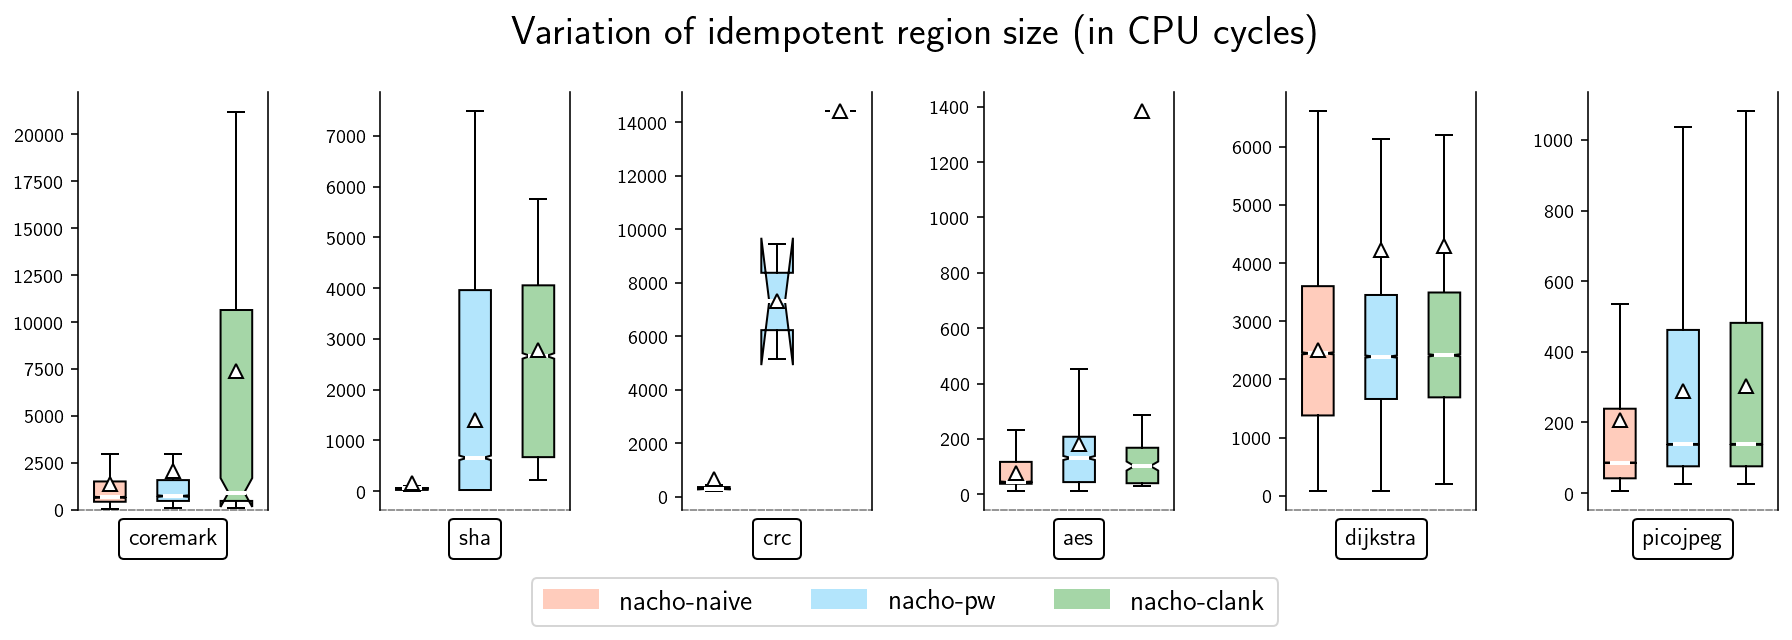

In [128]:
from BenchmarkConfiguration import *
isProwlUsed = False

fig, axs = plt.subplots(1, 6, sharex=False, figsize=(13,4))
plt.subplots_adjust(hspace=0.1)
fig.tight_layout(pad=3);

ax = [None, None, None, None, None, None]
k = 0
for j in range(6):
    ax[k] = axs[j]
    k = k + 1

group_spacing = 1
bar_spacing = 1
bar_width = 0.5

idx = 0
idy = 0
idk = 0
cache_config_used = "-512-2-"
for configs in cont_stats[cache_config_used]:
    if configs == 'prowl' and isProwlUsed == False:
        continue

    idy = 0
    for bmark in cont_stats[cache_config_used][configs]:
        data = cont_stats[cache_config_used][configs][bmark]["last checkpoint"]
        pos = idx * bar_spacing
        b = ax[idy].boxplot(data, notch=True, patch_artist=True,
                       widths=bar_width, positions=[pos], showfliers=False, 
                       labels=[ConfigurationNameMap[configs]], showmeans=True,
                       boxprops=dict(facecolor=ConfigurationColorMap[configs], linewidth=1),
                       medianprops=dict(color='white', linewidth=2),
                       meanprops=dict(color='black', markeredgecolor='black', markerfacecolor='white', markersize=7),
                      );
        idy = idy + 1
    idx = idx + 1

idx = 0
xlim = [-0.18, 0.7]
for x in ax:
    x.axes.xaxis.set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['bottom'].set_linestyle('--')
    x.spines['bottom'].set_alpha(0.5)

    at = AnchoredText(Benchmarks[idx], prop=dict(size=12), frameon=True, loc='center', bbox_to_anchor=[0.5,-0.07], bbox_transform=x.transAxes)
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    idx = idx+1
    x.add_artist(at)

# For the legend
n=[];
h,l = ax[0].get_legend_handles_labels();
labels = Configurations;

if isProwlUsed == False:
    labels = Configurations[:3]

for i in range(len(Benchmarks)):
    n.append(ax[0].bar(0, 0, color=StackedBarColors[i][0]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-4.1, -0.272, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Variation of idempotent region size (in CPU cycles)',fontsize=20, x=0.5, y=1.02);

fig.savefig('plots/cycles-checkpoints-diff.pdf', bbox_inches='tight');

In [75]:
final_stats["-512-2-"]["nacho-clank"]["coremark"]["cache_checkpoint"] - final_stats["-512-2-"]["nacho-pw"]["coremark"]["cache_checkpoint"]

-91804

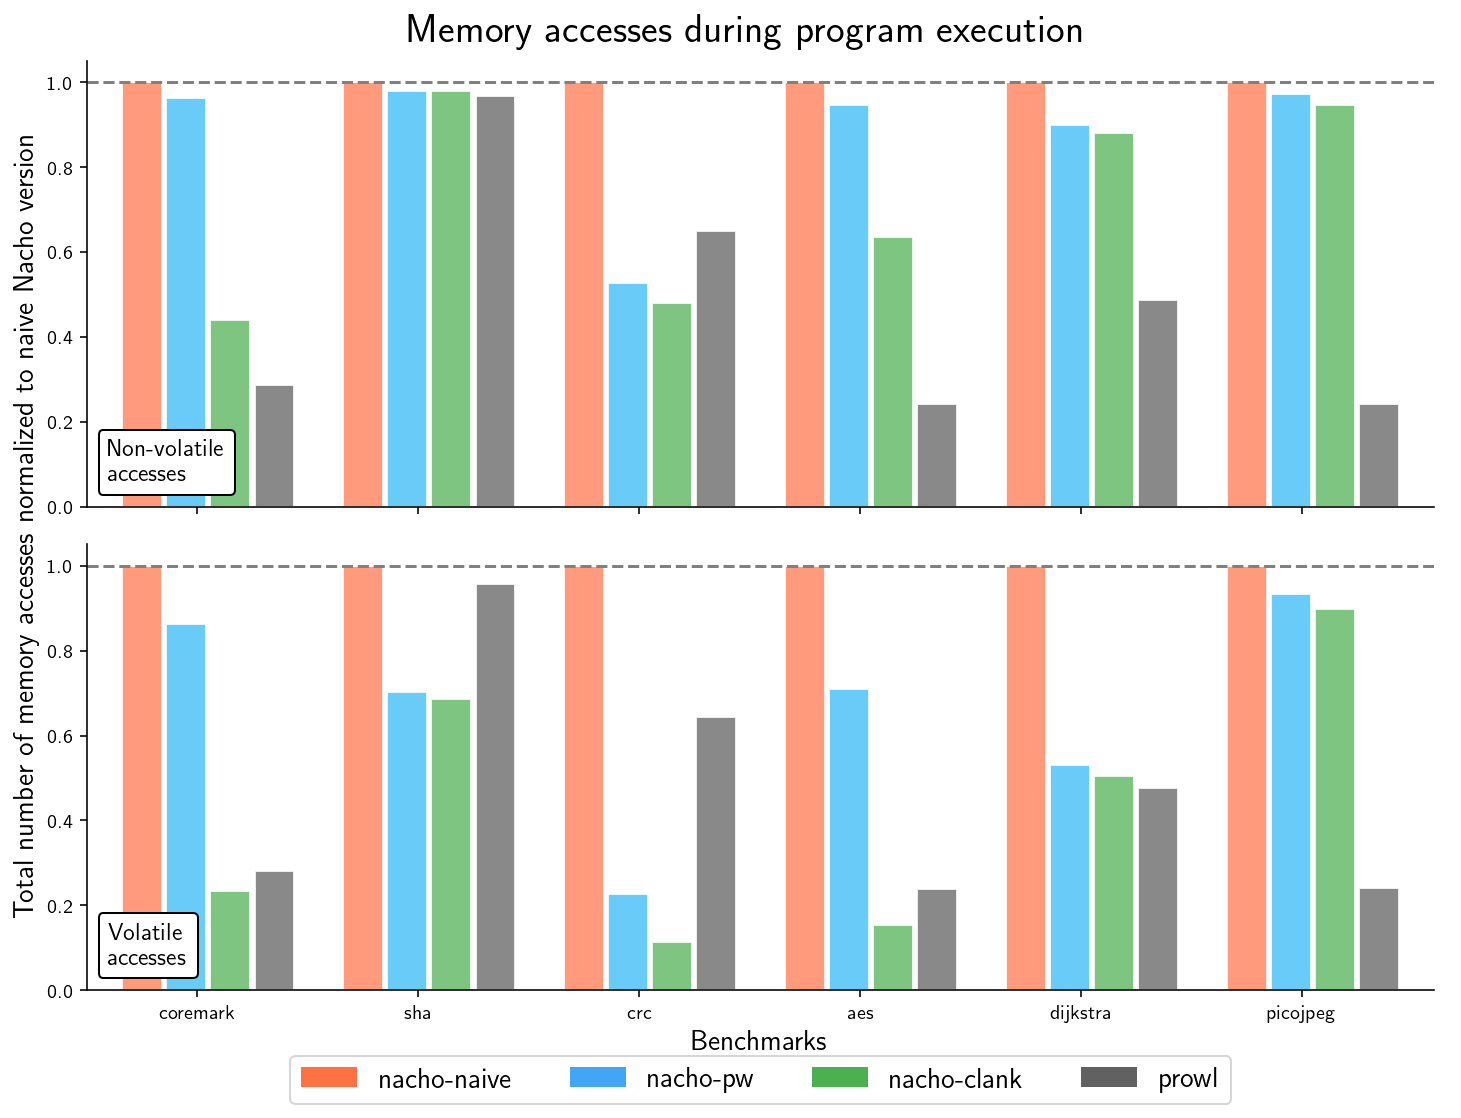

In [134]:
stats_plotted = ['nvm_writes']
stats_desc = ['Execution Cycle']
title = 'Number of cycles'
normalizationBmark = "nacho-naive"
isCheckpoints = True

fig, ax_np = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7), sharey=True);
fig.tight_layout(pad=1);
ylegend = 1.2

ax = [None, None]
k = 0
for j in range(2):
    ax[k] = ax_np[j]
    k = k + 1

for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks, fontsize=14);
isCheckpoints = False

# Do the actual plotting
def doActualPlotting(thisax, cache_config, stats, norm, title, cache_text):
    global cache_config_used
    cache_config_used = cache_config
    plotStatPerBenchmark(thisax, stats, norm, title, startColor=1);
    at = AnchoredText(cache_text, prop=dict(size=12), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    thisax.add_artist(at)
    thisax.set_ylabel("")

doActualPlotting(ax[0], "-512-2-", ["nvm_writes"], normalizationBmark, "", "Non-volatile\naccesses")
doActualPlotting(ax[1], "-512-2-", ["cache_checkpoint"], normalizationBmark, "", "Volatile\naccesses")
# doActualPlotting(ax[2], "-512-2-", ["checkpoint"], normalizationBmark, "", "Checkpoints")
# doActualPlotting(ax[3], "-512-2-", ["cycle"], normalizationBmark, "", "Execution\ncycles")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for a in ax:
    a.axhline(1, color='grey', linestyle='--')

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0, -0.252, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Memory accesses during program execution',fontsize=20, x=0.5, y=1.02);

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
plt.ylabel("Total number of memory accesses normalized to naive Nacho version", fontsize=14);
plt.xlabel("Benchmarks", fontsize=14);

fig.savefig('plots/memory-access-variation.pdf', bbox_inches='tight');

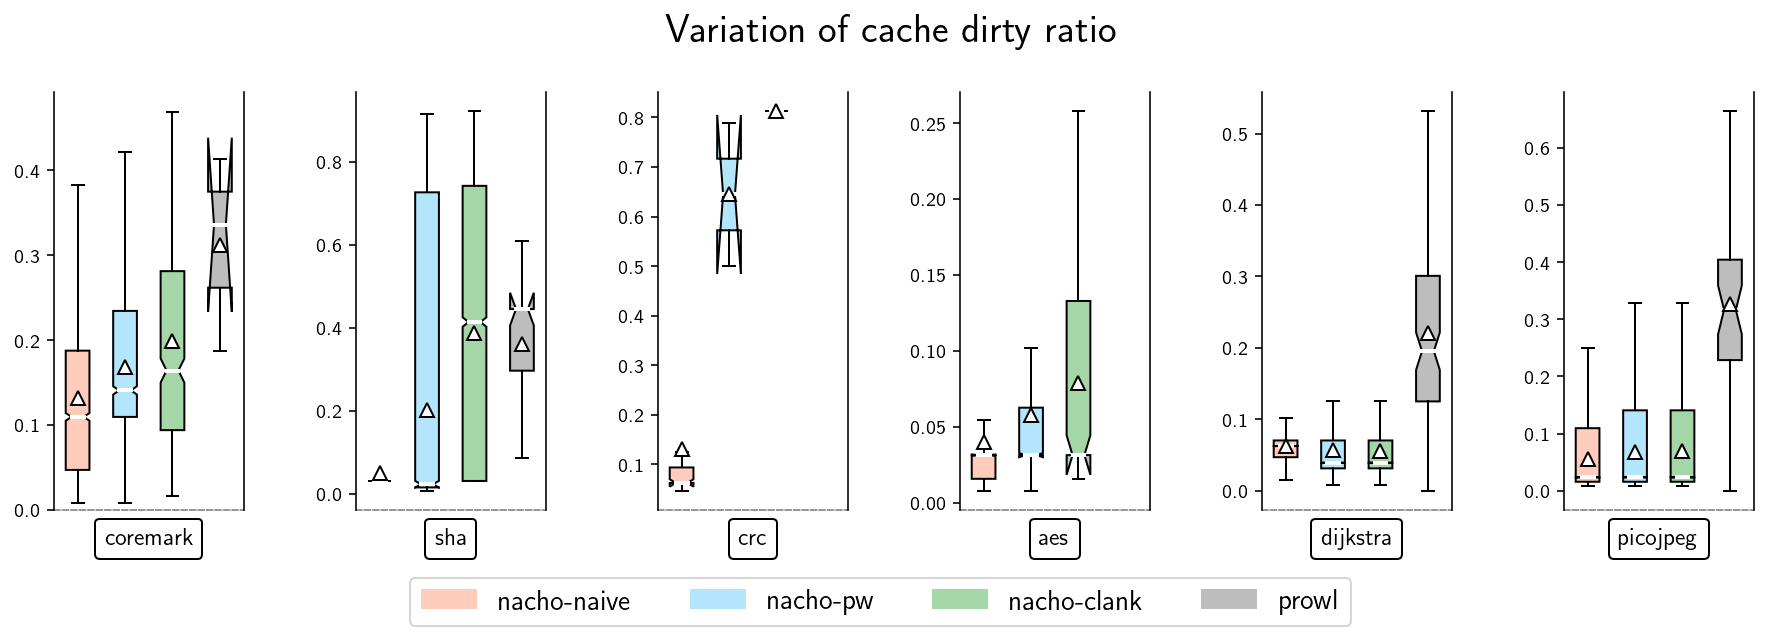

In [130]:
from BenchmarkConfiguration import *
isProwlUsed = True

fig, axs = plt.subplots(1, 6, sharex=False, figsize=(13,4))
plt.subplots_adjust(hspace=0.1)
fig.tight_layout(pad=3);

ax = [None, None, None, None, None, None]
k = 0
for j in range(6):
    ax[k] = axs[j]
    k = k + 1

group_spacing = 1
bar_spacing = 1
bar_width = 0.5

idx = 0
idy = 0
idk = 0
cache_config_used = "-512-2-"
for configs in cont_stats[cache_config_used]:
    if configs == 'prowl' and isProwlUsed == False:
        continue

    idy = 0
    for bmark in cont_stats[cache_config_used][configs]:
        data = cont_stats[cache_config_used][configs][bmark]["dirty ratio"]
        pos = idx * bar_spacing
        b = ax[idy].boxplot(data, notch=True, patch_artist=True,
                       widths=bar_width, positions=[pos], showfliers=False, 
                       labels=[ConfigurationNameMap[configs]], showmeans=True,
                       boxprops=dict(facecolor=ConfigurationColorMap[configs], linewidth=1),
                       medianprops=dict(color='white', linewidth=2),
                       meanprops=dict(color='black', markeredgecolor='black', markerfacecolor='white', markersize=7),
                      );
        idy = idy + 1
    idx = idx + 1

idx = 0
xlim = [-0.18, 0.7]
for x in ax:
    x.axes.xaxis.set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['bottom'].set_linestyle('--')
    x.spines['bottom'].set_alpha(0.5)

    at = AnchoredText(Benchmarks[idx], prop=dict(size=12), frameon=True, loc='center', bbox_to_anchor=[0.5,-0.07], bbox_transform=x.transAxes)
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    idx = idx+1
    x.add_artist(at)

# For the legend
n=[];
h,l = ax[0].get_legend_handles_labels();
labels = Configurations;

if isProwlUsed == False:
    labels = Configurations[:3]

for i in range(len(Benchmarks)):
    n.append(ax[0].bar(0, 0, color=StackedBarColors[i][0]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(-4.1, -0.272, 1., .102), 
            loc='center', fancybox=True,
            ncol=4, fontsize=14);

sup = plt.suptitle('Variation of cache dirty ratio',fontsize=20, x=0.5, y=1.02);

fig.savefig('plots/dirty-ratio-diff.pdf', bbox_inches='tight');

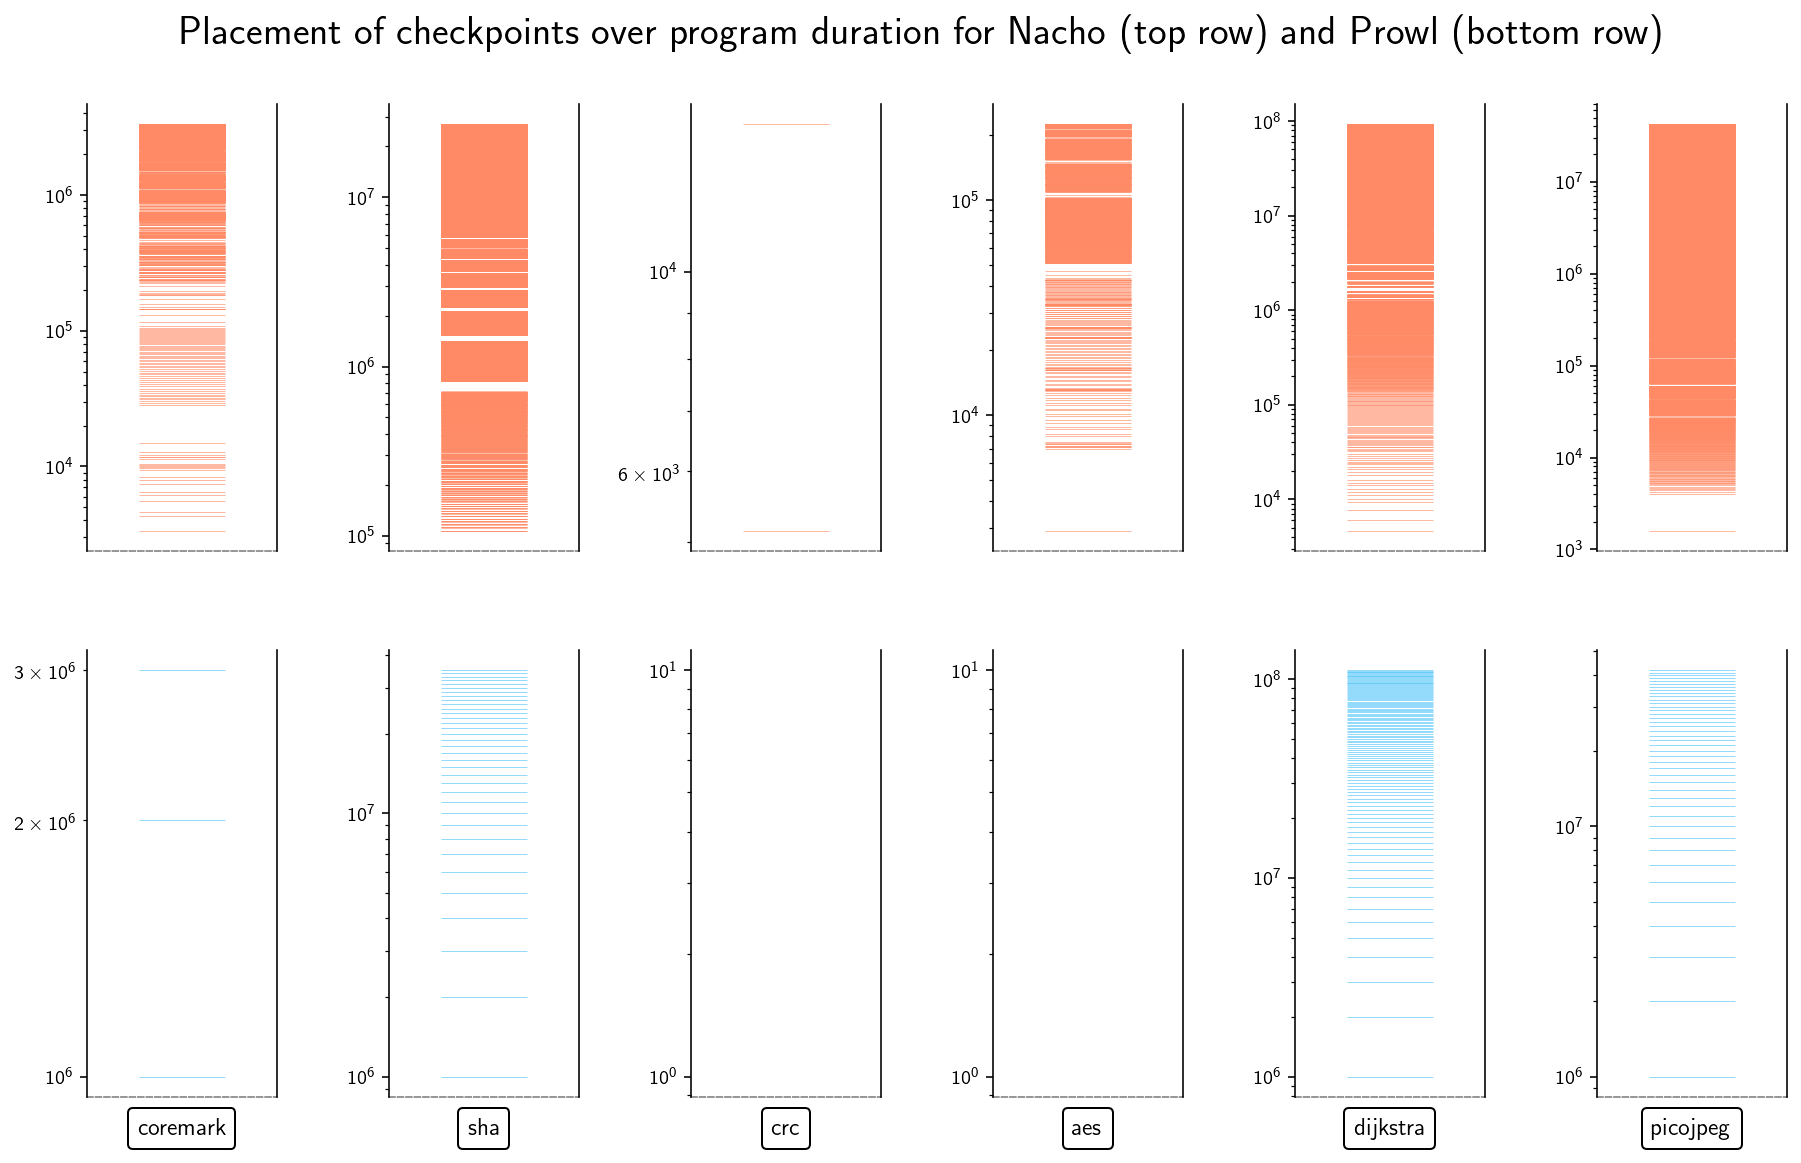

In [131]:
from BenchmarkConfiguration import *
isProwlUsed = True

fig, axs = plt.subplots(2, 6, sharex=False, figsize=(13,8))
plt.subplots_adjust(hspace=0.1)
fig.tight_layout(pad=3);

ax = []
for _ in range(12):
    ax.append(None)

k = 0
for i in range(2):
    for j in range(6):
        ax[k] = axs[i][j]
        k = k + 1

group_spacing = 1
bar_spacing = 1
bar_width = 0.5

idx = 0
idy = 0
idk = 0
cache_config_used = "-512-2-"
configs = "nacho-pw"

idy = 0
for bmark in cont_stats[cache_config_used][configs]:
    data = cont_stats[cache_config_used][configs][bmark]["cycle count"]
    pos = idx * bar_spacing
    b = ax[idy].eventplot(data, orientation='vertical', color="#FF8A65", linewidth=0.3);
    idy = idy + 1

configs = "prowl"
for bmark in cont_stats[cache_config_used][configs]:
    data = cont_stats[cache_config_used][configs][bmark]["cycle count"]
    pos = idx * bar_spacing
    b = ax[idy].eventplot(data, orientation='vertical', color="#4FC3F7", linewidth=0.3);
    idy = idy + 1

idx = 0
xlim = [-0.18, 0.7]
for x in ax:
    x.axes.set_yscale('log')
    x.axes.xaxis.set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['bottom'].set_linestyle('--')
    x.spines['bottom'].set_alpha(0.5)

for x in ax[6:]:
    at = AnchoredText(Benchmarks[idx % 6], prop=dict(size=12), frameon=True, loc='center', bbox_to_anchor=[0.5,-0.07], bbox_transform=x.transAxes)
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    idx = idx+1
    x.add_artist(at)

sup = plt.suptitle('Placement of checkpoints over program duration for Nacho (top row) and Prowl (bottom row)',fontsize=20, x=0.5, y=1.02);

fig.savefig('plots/placement-checkpoints-compare.pdf', bbox_inches='tight');

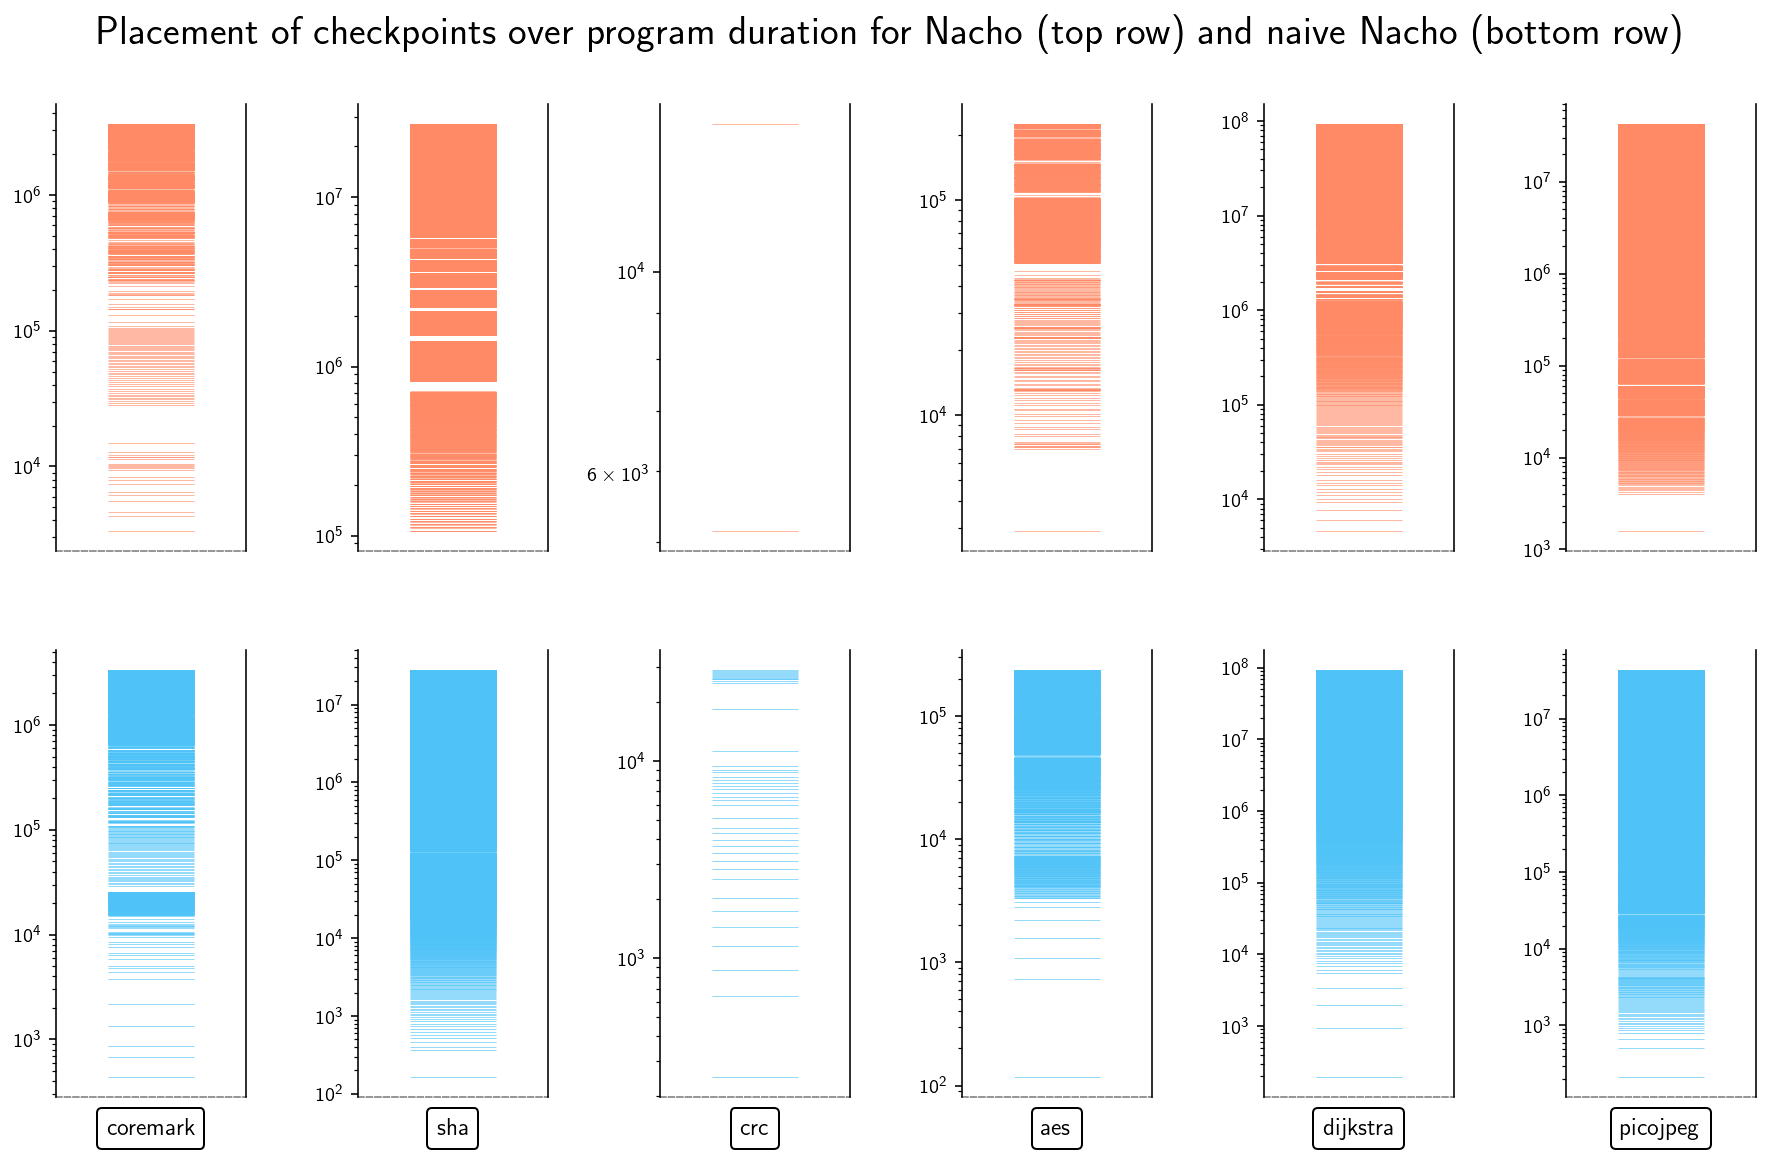

In [132]:
from BenchmarkConfiguration import *
isProwlUsed = True

fig, axs = plt.subplots(2, 6, sharex=False, figsize=(13,8))
plt.subplots_adjust(hspace=0.1)
fig.tight_layout(pad=3);

ax = []
for _ in range(12):
    ax.append(None)

k = 0
for i in range(2):
    for j in range(6):
        ax[k] = axs[i][j]
        k = k + 1

group_spacing = 1
bar_spacing = 1
bar_width = 0.5

idx = 0
idy = 0
idk = 0
cache_config_used = "-512-2-"
configs = "nacho-pw"

idy = 0
for bmark in cont_stats[cache_config_used][configs]:
    data = cont_stats[cache_config_used][configs][bmark]["cycle count"]
    pos = idx * bar_spacing
    b = ax[idy].eventplot(data, orientation='vertical', color="#FF8A65", linewidth=0.3);
    idy = idy + 1

configs = "nacho-naive"
for bmark in cont_stats[cache_config_used][configs]:
    data = cont_stats[cache_config_used][configs][bmark]["cycle count"]
    pos = idx * bar_spacing
    b = ax[idy].eventplot(data, orientation='vertical', color="#4FC3F7", linewidth=0.3);
    idy = idy + 1

idx = 0
xlim = [-0.18, 0.7]
for x in ax:
    x.axes.set_yscale('log')
    x.axes.xaxis.set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['bottom'].set_linestyle('--')
    x.spines['bottom'].set_alpha(0.5)

for x in ax[6:]:
    at = AnchoredText(Benchmarks[idx % 6], prop=dict(size=12), frameon=True, loc='center', bbox_to_anchor=[0.5,-0.07], bbox_transform=x.transAxes)
    at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
    idx = idx+1
    x.add_artist(at)

sup = plt.suptitle('Placement of checkpoints over program duration for Nacho (top row) and naive Nacho (bottom row)',fontsize=20, x=0.5, y=1.02);

fig.savefig('plots/naive-nacho-checkpoints-compare.pdf', bbox_inches='tight');